# Make a Gardner-Altman Plot

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Get seaborn's fMRI dataset but remove the time variable & group it
df = sns.load_dataset('fmri')
df['subject'] = df['subject'].str.extract('(\d+)').astype(int)
df = df.sort_values(by='subject').reset_index(drop=True)
df = df.groupby(['subject', 'event', 'region'], as_index=False)['signal'].mean()
df.head(12)

,subject,event,region,signal
0,0,cue,frontal,0.013769
1,0,cue,parietal,0.006717
2,0,stim,frontal,-0.006226
3,0,stim,parietal,0.001046
4,1,cue,frontal,-0.008762
5,1,cue,parietal,-0.015268
6,1,stim,frontal,0.020972
7,1,stim,parietal,0.042970
8,2,cue,frontal,-0.001531
9,2,cue,parietal,0.003215


In [278]:
def chopplot(plot_type, data, side=-1, ax=None, **kwargs):
    # Takes a plotting function from seaborn that supports a 'hue' argument.
    
    data_ = ghost_hue(data=data, y=y)
    
    if kwargs.get('x') is None:
        data_['X'] = 'i'
        kwargs['x'] = 'X'
    
    # Determine which side to make viewable and which to ghost
    if side == -1:
        viewhue, ghosthue = 'A', 'B'
    else:
        viewhue, ghosthue = 'B', 'A'
    
    # Get the y lims for the viewable side
    ymin, ymax = data_.loc[data_['_hue']==viewhue][y].min(), data_.loc[data_['_hue']==viewhue][y].max()
    
    # Ghost it by making all its values extreme
    data_.loc[data_['_hue'] == ghosthue, y] = 9999
    
    if ax is None:
        fig, ax = plt.subplots()
    
    if plot_type == 'violin':
        plot_func = sns.violinplot
        kwargs['split'] = kwargs.get('split', True)
        kwargs['inner'] = kwargs.get('inner', None)
    elif plot_type == 'strip':
        plot_func = sns.stripplot
        kwargs['dodge'] = kwargs.get('dodge', True)
    elif plot_type == 'swarm':
        plot_func = sns.swarmplot
    elif plot_type == 'box':
        plot_func = sns.boxplot
    
    plot_func(data=data_, hue='_hue', **kwargs, ax=ax)
    ax.set(ylim=(ymin - ((ymax-ymin)*.5), ymax + ((ymax-ymin)*.5)))
    ax.get_legend().remove()
    return ax

# Take a dataframe and duplicate it to create the ghost hue
def ghost_hue(data, y: str = None, side=-1):
    A = data.copy()
    A['_hue'] = 'A'
    B = A.copy()
    B['_hue'] = 'B'
    return pd.concat([A, B])

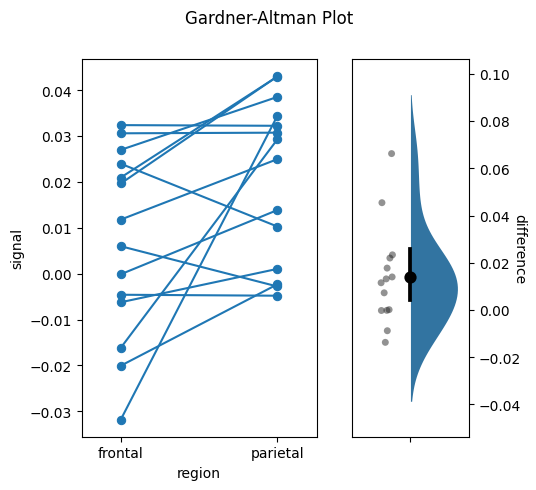

In [308]:
# Single factor
factor = 'region'
subject = 'subject'

data = df.loc[df['event']=='stim'].drop('event', axis=1)

# Get the difference
wide = data.set_index([subject, factor]).unstack(1)
wide.columns = [j for i, j in wide.columns]
wide

a, b = 'frontal', 'parietal'

wide['difference'] = wide[b] - wide[a]

fig, ax = plt.subplots(1, 2, figsize=(5,5), dpi=100, gridspec_kw={'width_ratios': [2,1]})

# Paired plot
sns.lineplot(data=data, x='region', y='signal', units='subject', estimator=None, marker='o', markeredgecolor=None, ax=ax[0])

# Difference plotting
chopplot(plot_type='violin', data=wide, y='difference', color='C0', linewidth=0, alpha=0.5, side=1, ax=ax[1])
chopplot(plot_type='strip', data=wide, y='difference', linewidth=0, alpha=0.5, side=-1, color='k', ax=ax[1], zorder=999)
sns.pointplot(data=wide, y='difference', color='k', zorder=999, ax=ax[1], ci=95)

# Formatting
ax[0].set(xlim=(-0.25, 1.25))
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[1].set_ylabel(ax[1].get_ylabel(), rotation=-90)
ax[1].set(xlabel=None)
plt.suptitle('Gardner-Altman Plot')
plt.show()